# Implémentez un modèle de scoring


Etude data - Projet 7 - Mars 2021

*Data source* : [Jeu de données d’articles](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

---

## Rappel de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

## Code de la modélisation
Dans le Notebook Jupyter nous avons vu l'exploration, ainsi que le prétraitement des données. Ici nous utiliserons un GPU pour effectuer les modélisations Catboost, LightGBM & XGBoost. Ici nous sommes en Google Colab PRO, donc l'accès au GPU est illimité… _L'offre free ne permet pas de mener à bien ce projet, les limites ont rapidement étaient atteintes pour effectuer les différents tests._


In [1]:
#Test de l'activation du GPU
#Si le GPU est activé, il donnera la sortie suivante - '/ device: GPU: 0 '
import tensorflow as tf
tf.test.gpu_device_name ()

'/device:GPU:0'

In [ ]:
#Appareils utilisés lors de l'exécution du notebook dans le cloud
from tensorflow.python.client import device_lib 
device_lib.list_local_devices ()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16360478728543910270, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15505193728
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 678723616778043399
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [ ]:
#Vérification de la RAM
!cat /proc/meminfo

MemTotal:       26751704 kB
MemFree:        18582216 kB
MemAvailable:   24089964 kB
Buffers:          117536 kB
Cached:          2523264 kB
SwapCached:            0 kB
Active:          2782092 kB
Inactive:        4980908 kB
Active(anon):    2009992 kB
Inactive(anon):      408 kB
Active(file):     772100 kB
Inactive(file):  4980500 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               580 kB
Writeback:             0 kB
AnonPages:       5122172 kB
Mapped:           268032 kB
Shmem:              1012 kB
Slab:             220652 kB
SReclaimable:     155804 kB
SUnreclaim:        64848 kB
KernelStack:        5632 kB
PageTables:        16380 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    13375852 kB
Committed_AS:    8723632 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             2096 kB
AnonHugePages:   

---

In [1]:
pip install catboost 

     |████████████████████████████████| 67.3MB 86kB/s 


In [2]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 21795, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 21795 (delta 156), reused 189 (delta 101), pack-reused 21508
Receiving objects: 100% (21795/21795), 17.19 MiB | 23.43 MiB/s, done.
Resolving deltas: 100% (15908/15908), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused

In [3]:
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [5]:
import pandas as pd
import seaborn as sns
import time, pickle

from zipfile import ZipFile

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [8]:
#Download files from google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#Second solution >>> import files from your computer
#from google.colab import files
#uploaded = files.upload()
#for fn in uploaded.keys():
#  print('Vous avez importé le fichier "{name}" qui a une taille de {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Mounted at /content/gdrive


In [9]:
z = ZipFile("/content/gdrive/My Drive/Colab Notebooks/p7_00_data/data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)
data_train.shape

(307511, 309)

In [10]:
TARGET = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/p7_00_data/TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 309), (92254, 309), (215257, 1), (92254, 1))

### **Baseline model - Logistic Regression**
Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [13]:
from sklearn.linear_model import LogisticRegression

In [16]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
  '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
  fig = plt.figure(figsize=(20,15))
  
  plt.subplot(221)
  cf_matrix = confusion_matrix(y_true, y_pred)
  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

  plt.subplot(222)
  fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
  plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()

  if feature_importances : 
    plt.subplot(212)
    indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

  show()

In [14]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6939
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

CPU times: user 7.72 s, sys: 2.47 s, total: 10.2 s
Wall time: 2.72 s


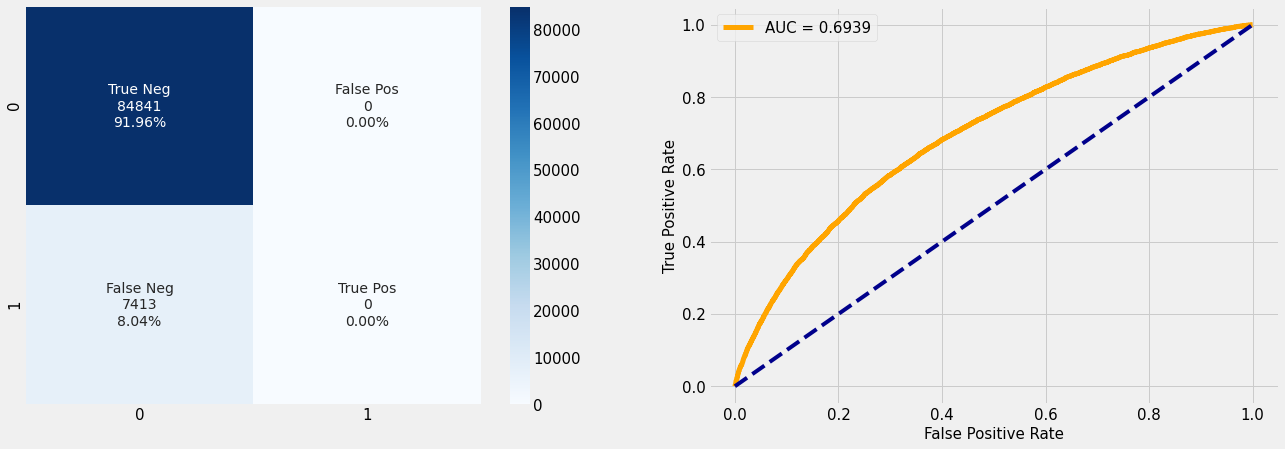

In [17]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français)  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

**Oversampling Data Using SMOTE**

SMOTE with Imbalance Data using imblearn module



In [18]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17412 
Label 0, Before using SMOTE: 197845 


In [19]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

CPU times: user 3min 9s, sys: 578 ms, total: 3min 10s
Wall time: 3min 9s


In [20]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


In [21]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7196
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.52     92254
weighted avg       0.89      0.67      0.75     92254

CPU times: user 31.3 s, sys: 8.46 s, total: 39.7 s
Wall time: 10.2 s


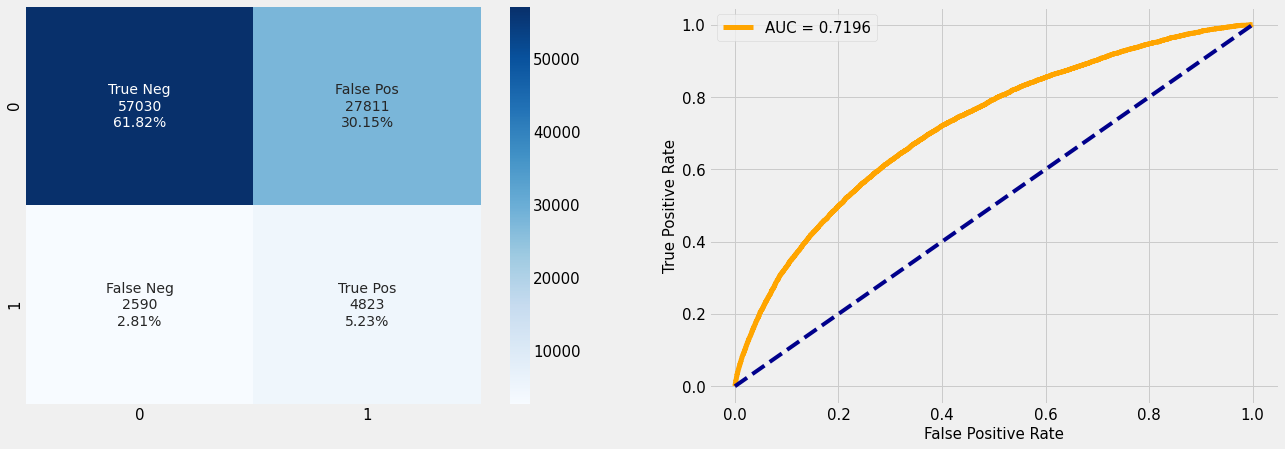

In [22]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Amélioration de l'AUC score 0.72 que nous prendrons comme baseline de travail pour la suite des essais…